In [2]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
import evals.teaching_evals as evals
import utils.gen_triplets as gen

sns.set_theme()
def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
def get_lpips_data(dataset, seeds):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    dist_M = pickle.load(open(f"data/dist/lpips/{dataset}/train_test.pkl","rb"))
    zs = [pickle.load(open(f"data/embeds/bm_lpips/TN_train_d50_seed{seed}.pkl","rb")) for seed in seeds]

    return dist_M, zs, y_train, y_test

def get_prolific_data(dataset, seeds):    
    transform = transforms.bird_transform()
    train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
    test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
    x_train = np.array([x[0].numpy() for x in train])
    x_test = np.array([x[0].numpy() for x in test])
    y_train = np.array([x[1] for x in train])
    y_test = np.array([x[1] for x in test])

    dist_Ms = [pickle.load(open(f"data/dist/prolific/{dataset}/train_test_seed{seed}.pkl","rb")) for seed in seeds]
    zs = [pickle.load(open(f"data/embeds/{dataset}_prolific/TN_train_d50_seed{seed}.pkl","rb")) for seed in seeds]

    return dist_Ms, zs, y_train, y_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
dataset = "bm"
seeds = np.arange(10)
dist_Ms, zs, y_train, y_test = get_lpips_data(dataset, seeds)
alg = algs.mmd_greedy
paired_zs = [evals.concat_embeds(z, y_train) for z in zs]

In [6]:
def CV_experiments(m_range, dist_M, teaching_alg, paired_z, z, y_train, y_test, sim=True):
    CV_scores, wCV_scores, CV_abs = np.zeros(len(m_range)), np.zeros(len(m_range)), np.zeros(len(m_range))

    sim_M = evals.dist2sim(dist_M) if sim else dist_M
    paired_z, idx = paired_z
    for j, m in enumerate(m_range):
        S_concat = teaching_alg(paired_z, m)
        S_pairs = idx[S_concat]
        S_single = teaching_alg(z, m)
        CV_scores[j] = evals.eval_CV(sim_M, S_pairs, y_train, y_test, weighted=False, sim=sim)
        wCV_scores[j] = evals.eval_CV(sim_M, S_pairs, y_train, y_test, weighted=True, sim=sim)
        CV_abs[j] = evals.eval_CV_abs(sim_M, S_pairs, y_train, y_test, weighted=False, sim=sim)

    results = {
        "CV_scores": CV_scores,
        "wCV_scores": wCV_scores,
        "CV_abs_scores": CV_abs,
        }
    return results

In [63]:
CV_experiments(np.arange(5), dist_Ms, alg, paired_zs[0], zs[0], y_train, y_test, sim=True)

{'CV_scores': array([0.5  , 0.4  , 0.4  , 0.525, 0.525]),
 'wCV_scores': array([0.5  , 0.4  , 0.4  , 0.675, 0.65 ]),
 'CV_abs_scores': array([0.5, 0.4, 0.4, 0.7, 0.7])}

In [ ]:
X = plot.plot_data(zs[1],y_train)

In [60]:
dist_M = dist_Ms
sim_M = evals.dist2sim(dist_M)
paired_z, idx = paired_zs[1]
S_concat = alg(paired_z, 3)
S_pairs = idx[S_concat]
S_pairs

array([[29, 99],
       [ 7, 60],
       [ 4, 68]])

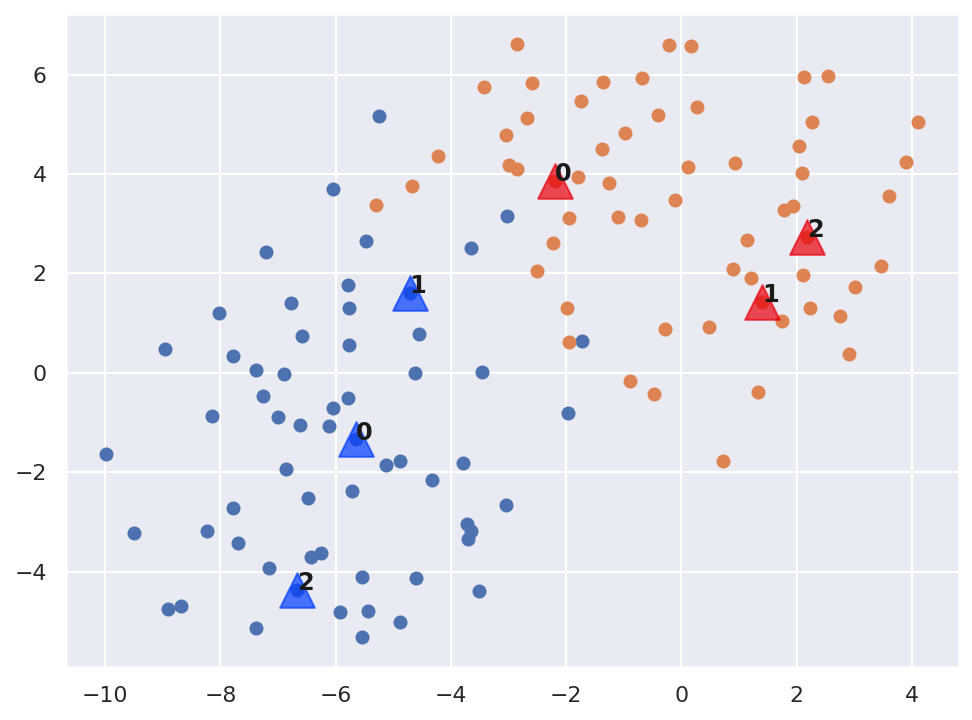

In [62]:
sns.set_color_codes("bright")
Y = y_train
classes = np.unique(Y)
plt.figure(figsize=(8, 6))
colors = ['b', 'r']
for c in classes:
    c_idx = np.where(Y==c)[0]
    plt.scatter(X[c_idx][:,0], X[c_idx][:,1])

for i, pair in enumerate(S_pairs):
    for x in pair:
        c = y_train[x]
        plt.scatter(X[x][0], X[x][1], marker='^', s=300, c=colors[c], alpha=0.7)
        plt.text(X[x][0], X[x][1], str(i), c='k', weight='bold')